In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [2]:
(X_train, _), (_, _) = mnist.load_data()

# Normalize to range [-1, 1]
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(X_train.shape[0], 784)  # Flatten

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((28, 28)))
    return model

In [4]:
def build_discriminator(img_shape=(28, 28)):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [5]:
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator(latent_dim)

discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = {"d_loss": [], "d_acc": [], "g_loss": []}

def train(epochs=10000, batch_size=64, save_interval=2000):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(1, epochs+1):
        # ---- Train Discriminator ----
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx].reshape(batch_size, 28, 28)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Train Generator ----
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real)

        # ---- Store history ----
        history["d_loss"].append(d_loss[0])
        history["d_acc"].append(d_loss[1])
        history["g_loss"].append(g_loss)

        # ---- Print progress ----
        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

        # ---- Save sample images ----
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [8]:
def save_imgs(epoch, examples=25):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    gen_imgs = generator.predict(noise, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0,1]

    plt.figure(figsize=(5,5))
    for i in range(examples):
        plt.subplot(5,5,i+1)
        plt.imshow(gen_imgs[i,:,:,], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

In [9]:
def plot_history():
    plt.figure(figsize=(15,5))

    # Losses
    plt.subplot(1,3,1)
    plt.plot(history["d_loss"], label="Discriminator Loss")
    plt.plot(history["g_loss"], label="Generator Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history["d_acc"], label="Discriminator Accuracy")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Combined Loss curve for comparison
    plt.subplot(1,3,3)
    plt.plot(history["d_loss"], label="D Loss")
    plt.plot(history["g_loss"], label="G Loss")
    plt.title("Generator vs Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


500 [D loss: 4.9449, acc: 50.03] [G loss: 0.0037]
1000 [D loss: 5.5622, acc: 50.01] [G loss: 0.0019]
1500 [D loss: 5.9213, acc: 50.01] [G loss: 0.0012]
2000 [D loss: 6.1778, acc: 50.01] [G loss: 0.0009]


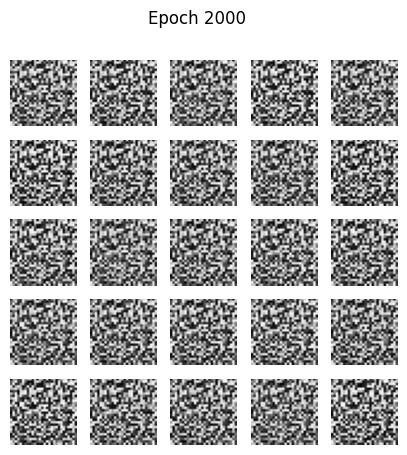

2500 [D loss: 6.3798, acc: 50.01] [G loss: 0.0007]
3000 [D loss: 6.5477, acc: 50.00] [G loss: 0.0006]
3500 [D loss: 6.6916, acc: 50.00] [G loss: 0.0005]
4000 [D loss: 6.8188, acc: 50.00] [G loss: 0.0005]


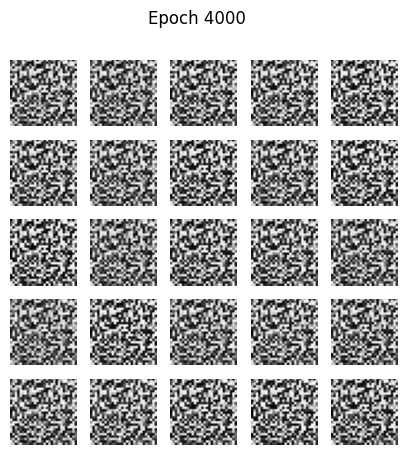

4500 [D loss: 6.9338, acc: 50.00] [G loss: 0.0004]
5000 [D loss: 7.0387, acc: 50.00] [G loss: 0.0004]


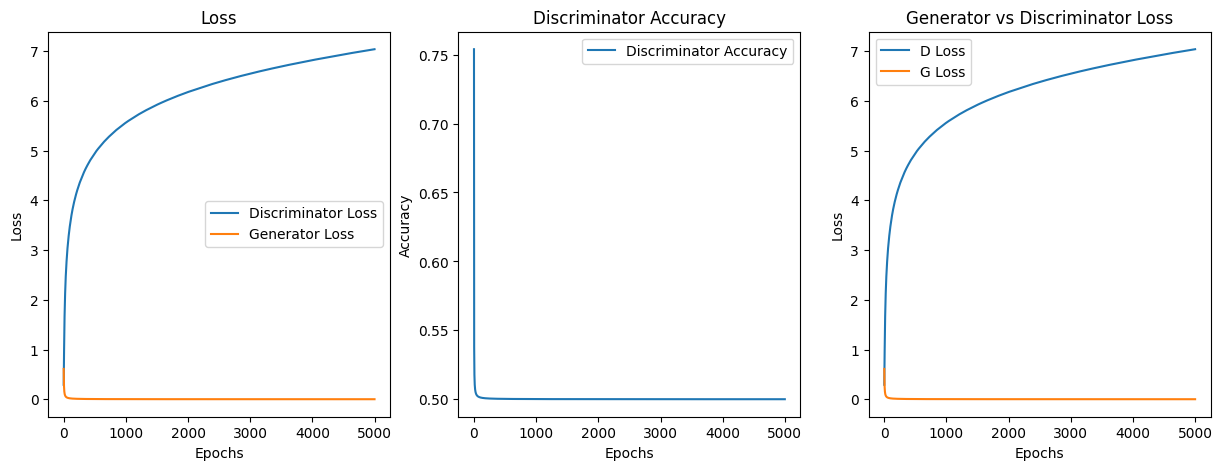

In [10]:
train(epochs=5000, batch_size=64, save_interval=2000)
plot_history()